# Final Exercise overview
The final exercise will comprise a bunch of mini-projects, together which will approximate a set of analysis tasks required during an emergency response.

The tasks will be categorized into different response functions, loosely according to the Incident Command Structure. We will initially put people into groups based on their interests, just to make sure every task has some people working on it, but people are free to move between tasks as needed. Be sure to communicate amongst the tasks to let each other know when you could use more people or have downtime and can offer help to others.

### Grid
First, we will go over the game grid.

In [5]:
# install and import dependencies
!pip install dwave_networkx
!pip install vrpy
import geopandas as gpd
import numpy as np
import dimod
import networkx as nx
import pandas as pd
import dwave_networkx as dnx
import seaborn as sns
import pickle
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from tqdm import tqdm
from vrpy import VehicleRoutingProblem

In [1]:
!wget 

total 13160
-rw-rw-r-- 1 jovyan users       10 Jul 27 15:03 game_grid_all_stats.cpg
-rw-rw-r-- 1 jovyan users 11171216 Jul 27 15:03 game_grid_all_stats.dbf
-rw-rw-r-- 1 jovyan users      402 Jul 27 15:03 game_grid_all_stats.prj
-rw-rw-r-- 1 jovyan users  2161140 Jul 27 15:03 game_grid_all_stats.shp
-rw-rw-r-- 1 jovyan users   127220 Jul 27 15:03 game_grid_all_stats.shx


In [8]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1mX-mwgBz04nf8SOxKF2YVC3rkdbMa8PX' -O out.geojson

--2020-07-29 19:56:50--  https://docs.google.com/uc?export=download&id=1mX-mwgBz04nf8SOxKF2YVC3rkdbMa8PX
Resolving docs.google.com (docs.google.com)... 172.217.9.46, 2607:f8b0:4009:804::200e
Connecting to docs.google.com (docs.google.com)|172.217.9.46|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-c8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8jfonf8aim4hda5vcio9u18phiqa3rb6/1596052575000/02631699668576268955/*/1mX-mwgBz04nf8SOxKF2YVC3rkdbMa8PX?e=download [following]
--2020-07-29 19:56:50--  https://doc-0o-c8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8jfonf8aim4hda5vcio9u18phiqa3rb6/1596052575000/02631699668576268955/*/1mX-mwgBz04nf8SOxKF2YVC3rkdbMa8PX?e=download
Resolving doc-0o-c8-docs.googleusercontent.com (doc-0o-c8-docs.googleusercontent.com)... 172.217.4.97, 2607:f8b0:4009:812::2001
Connecting to doc-0o-c8-docs.googleusercontent.com (doc-0o-c8-docs.googleuserc

In [9]:
# read game_grid as GeoDataFrame and correct CRS (Coordinate Reference System)
game_grid = gpd.read_file('out.geojson')
game_grid.crs='epsg:3857'
game_grid

,MGRS,kmSQ_ID,GZD,EASTING,NORTHING,MGRS_10km,Shape_Leng,Shape_Le_1,Shape_Area,x_centroid,y_centroid,Health,Utility,Transport,population,SVI,geometry
0,19TBH7264,BH,19T,272000mE,4764000mN,19TBH76,0.042522,0.042522,0.000110,-71.791007,42.999142,9,7,3,15.0,0.2113,"POLYGON ((-7991033.712 5311179.522, -7992397.7..."
1,19TBH7364,BH,19T,273000mE,4764000mN,19TBH76,0.042523,0.042523,0.000110,-71.778753,42.999441,8,7,3,11.0,0.2113,"POLYGON ((-7989669.690 5311224.829, -7991033.7..."
2,19TBH7464,BH,19T,274000mE,4764000mN,19TBH76,0.042523,0.042523,0.000110,-71.766499,42.999738,8,7,3,14.0,0.2113,"POLYGON ((-7988305.646 5311269.937, -7989669.6..."
3,19TBH7564,BH,19T,275000mE,4764000mN,19TBH76,0.042523,0.042523,0.000110,-71.754245,43.000033,9,7,3,21.0,0.2113,"POLYGON ((-7986941.582 5311314.845, -7988305.6..."
4,19TBH7664,BH,19T,276000mE,4764000mN,19TBH76,0.042524,0.042524,0.000110,-71.741990,43.000328,9,7,3,28.0,0.0336,"POLYGON ((-7985577.497 5311359.555, -7986941.5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,19TDG1600,DG,19T,416000mE,4600000mN,19TDG10,0.041993,0.041993,0.000108,-70.001238,41.551809,7,2,2,0.0,0.0495,"POLYGON ((-7791827.195 5093415.199, -7793161.7..."
15886,19TDG1700,DG,19T,417000mE,4600000mN,19TDG10,0.041993,0.041993,0.000108,-69.989249,41.551913,9,3,3,0.0,0.0495,"POLYGON ((-7790492.658 5093430.539, -7791827.1..."
15887,19TDF1599,DF,19T,415000mE,4599000mN,19TDF19,0.041990,0.041990,0.000108,-70.013087,41.542698,7,4,3,0.0,0.0495,"POLYGON ((-7793146.168 5092060.201, -7794480.5..."
15888,19TDF1699,DF,19T,416000mE,4599000mN,19TDF19,0.041990,0.041990,0.000108,-70.001099,41.542803,10,5,1,0.0,0.0495,"POLYGON ((-7791811.823 5092075.720, -7793146.1..."


The game grid uses the [Military Grid Reference System (MGRS)](https://en.wikipedia.org/wiki/Military_Grid_Reference_System) which breaks the world up into 1-km square cells. The MGRS column is an alphanumeric code which uniquely refers to each of those cells.

Each cell has some important attributes:
- Population: how many people live in that cell
- Health: Average health (higher better)
- Utility: Average access to utilities (higher better)
- Transport: How easy is it to move through the cell (higher better)
- SVI: Social Vulnerability Index
 

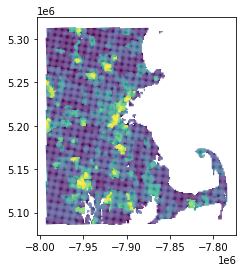

In [10]:
game_grid.plot('SVI')

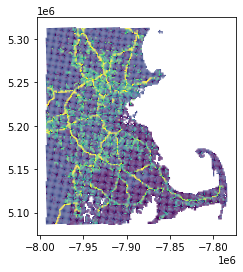

In [11]:
game_grid.plot('Transport')

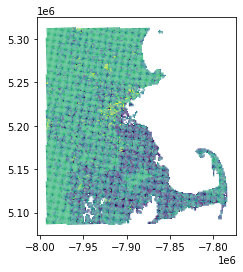

In [12]:
game_grid.plot('Utility')

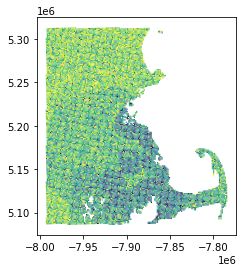

In [13]:
game_grid.plot('Health')

### Facilities
There are also a number of facilities shapefiles in the `facilities` folders which will be used for a number of the mini-projects.
- airfields: places where airplanes and helicopters can be flown in/from
- cell_towers: communications infrastructure
- EMS: ambulance services
- fire_stations: fire services
- hospitals: hospitals
- local_eocs: local emergency operations centers
- powerplants: energy generating facilities
- locations: places where people can be tended to
- state_eocs: state emergency operatins centers

# Logistics
## Routing and Resource Management
### Asset deployment
You have access to 1 helicopter, 20 tractor-trailer trucks, and 20 pickup trucks. You can set up a base at any of the airfields of your choice. You can have up to 2 bases. Where do you place your assets?
- helicopter: cost \$1000/hr to operate, 250 km/hr speed - air, capacity: 2
- tractor-trailer: cost \$50/hr to operate, 100 km/hr speed - land, capacity: 20
- pickup truck: cost \$20/hr to operate, 120 km/hr speed - land, capacity: 3

### Game grid to network conversion
Convert the game grid gdf to a `networkx` object where each cell of the grid is a node, and it is connected to each of its adjacent nodes by an edge. The edge weight between node `node_i` and its neighbor `node_j` is given by the pseudocode formula:
`weight_ij = (5/2)*((1/node_i.transport) + (1/node_j.transport))`

where `node_i.transport` is the transport score of the cell `i`. The travel time across edge `ij` is given by `weight_ij*(120/speed_in_kmh)` minutes.

The helicopter flies straight line to its targets and ignores the network weights.

### Vehicle Routing Problem
You will be given lists of facilities (from the ones in `facilities/`) you need to deliver supplies to. Create a tool to compute the routes you would take and the vehicles you would use in order to get the supplies to those facilities. The vehicles must begin and end their trip at one of your bases, but they do not necessarily need to end at the same one they began at. You will be given a budget and time frame, and you want to deliver as many supplies as possible to those facilities within your time frame and budget. 

In [14]:
game_grid # print out initial game_grid to check data

,MGRS,kmSQ_ID,GZD,EASTING,NORTHING,MGRS_10km,Shape_Leng,Shape_Le_1,Shape_Area,x_centroid,y_centroid,Health,Utility,Transport,population,SVI,geometry
0,19TBH7264,BH,19T,272000mE,4764000mN,19TBH76,0.042522,0.042522,0.000110,-71.791007,42.999142,9,7,3,15.0,0.2113,"POLYGON ((-7991033.712 5311179.522, -7992397.7..."
1,19TBH7364,BH,19T,273000mE,4764000mN,19TBH76,0.042523,0.042523,0.000110,-71.778753,42.999441,8,7,3,11.0,0.2113,"POLYGON ((-7989669.690 5311224.829, -7991033.7..."
2,19TBH7464,BH,19T,274000mE,4764000mN,19TBH76,0.042523,0.042523,0.000110,-71.766499,42.999738,8,7,3,14.0,0.2113,"POLYGON ((-7988305.646 5311269.937, -7989669.6..."
3,19TBH7564,BH,19T,275000mE,4764000mN,19TBH76,0.042523,0.042523,0.000110,-71.754245,43.000033,9,7,3,21.0,0.2113,"POLYGON ((-7986941.582 5311314.845, -7988305.6..."
4,19TBH7664,BH,19T,276000mE,4764000mN,19TBH76,0.042524,0.042524,0.000110,-71.741990,43.000328,9,7,3,28.0,0.0336,"POLYGON ((-7985577.497 5311359.555, -7986941.5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,19TDG1600,DG,19T,416000mE,4600000mN,19TDG10,0.041993,0.041993,0.000108,-70.001238,41.551809,7,2,2,0.0,0.0495,"POLYGON ((-7791827.195 5093415.199, -7793161.7..."
15886,19TDG1700,DG,19T,417000mE,4600000mN,19TDG10,0.041993,0.041993,0.000108,-69.989249,41.551913,9,3,3,0.0,0.0495,"POLYGON ((-7790492.658 5093430.539, -7791827.1..."
15887,19TDF1599,DF,19T,415000mE,4599000mN,19TDF19,0.041990,0.041990,0.000108,-70.013087,41.542698,7,4,3,0.0,0.0495,"POLYGON ((-7793146.168 5092060.201, -7794480.5..."
15888,19TDF1699,DF,19T,416000mE,4599000mN,19TDF19,0.041990,0.041990,0.000108,-70.001099,41.542803,10,5,1,0.0,0.0495,"POLYGON ((-7791811.823 5092075.720, -7793146.1..."


In [15]:
# calculate basic flood risk heuristic based on distance to two coastline points
game_grid['FLOOD_RISK']=-np.minimum(np.sqrt((game_grid['x_centroid']+70.3)**2+(game_grid['y_centroid']-42.2)**2),
                                    np.sqrt((game_grid['x_centroid']+70.2)**2+(game_grid['y_centroid']-41.4)**2))
game_grid['FLOOD_RISK']-=np.min(game_grid['FLOOD_RISK'])
game_grid['FLOOD_RISK']/=np.max(game_grid['FLOOD_RISK'])

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [16]:
# calculate risk based upon flood risk and SVI (Social Vulnerability Index)
game_grid['RISK']=game_grid['SVI']*(game_grid['FLOOD_RISK'])*0.9+0.1

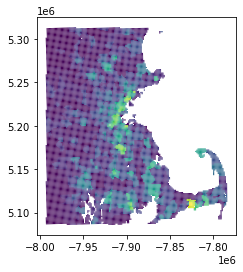

In [17]:
game_grid.plot('RISK')

In [18]:
game_grid = game_grid.to_crs('epsg:4269') # convert geometry to latitude, longitude to match centroid location
game_grid['EAST'] = pd.to_numeric(game_grid['EASTING'].str[:-5]) # calculate grid east position from easting and ignore trailing 000mE
game_grid['NORTH'] = pd.to_numeric(game_grid['NORTHING'].str[:-5]) # calculate grid north position from northing and ignore trailing 000mN
game_grid_pos = game_grid.set_index(['EAST', 'NORTH']) # set index to grid position for seperate dataframe
game_grid = game_grid.set_index('MGRS') # use MGRS as main indexing method

In [19]:
# create a graph from GeoDataFrame connected as a grid
G = nx.Graph() # create empty networkx graph
for pos, cell in game_grid_pos.iterrows():
    for neighbor_pos in [(pos[0]+1, pos[1]), # east
                         (pos[0]-1, pos[1]), # west
                         (pos[0],   pos[1]+1), # north
                         (pos[0],   pos[1]-1)]: # south
        if neighbor_pos in game_grid_pos.index:
            neighbor = game_grid_pos.loc[neighbor_pos] # find neighbor in this direction
            G.add_edge(cell['MGRS'], # cell MGRS id, used as node id
                       neighbor['MGRS'], # neightbor MGRS id, used as node id
                       weight = (1/cell['Transport'] + 1/neighbor['Transport']) * 5/2) # weight from definition

In [20]:
nx.set_node_attributes(G, game_grid.to_dict('index')) # use pandas DataFrame for node data

In [21]:
bases = ('19TCG1685','19TCG1752') # choose two bases for routes

In [22]:
positions=game_grid[['x_centroid', 'y_centroid']].T.to_dict('list') # positions of nodes to plot

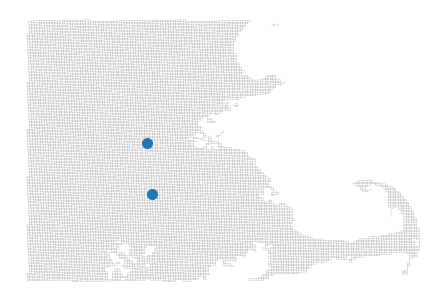

In [23]:
# draw networkx graph
# first draw edges
ax=nx.draw(G,
        positions, # use centroids for positions
        width = 0.1,
        node_size=0) # show thin edges
# then draw base nodes
nx.draw_networkx_nodes(G,
        positions, # use centroids for positions
        node_size = 100,
        nodelist = list(bases), # only showing bases 
        ax=ax)
plt.savefig('base_locations.svg', bbox_inches='tight')

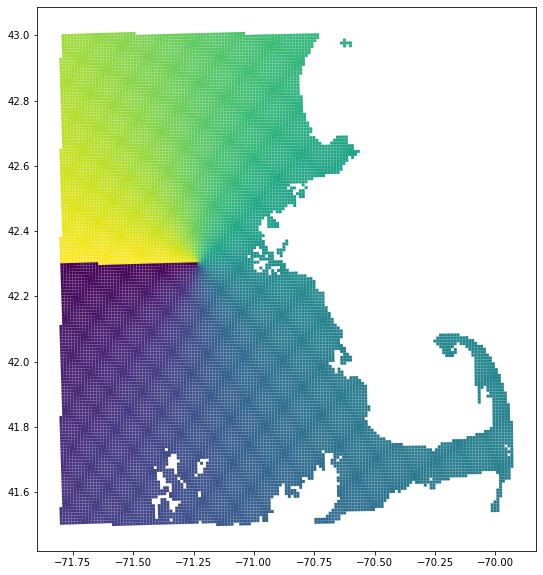

In [24]:
# save angle from first base to cell
game_grid['THETA'] = np.arctan2(game_grid['y_centroid']-game_grid.loc[bases[0],'y_centroid'],
                                game_grid['x_centroid']-game_grid.loc[bases[0],'x_centroid'])
game_grid.plot('THETA',figsize=(10,10))
plt.savefig('cell_angles.svg', bbox_inches='tight')

In [25]:
# save distance from first base to cell
game_grid['DISTANCE'] = pd.Series(nx.single_source_shortest_path_length(G,bases[0]))

In [26]:
location_type='all'

In [56]:
# load locations location from file and convert to same CRS as game_grid
shelters=gpd.read_file(f'facilities/shelters.shp').to_crs('epsg:4269')
hospitals=gpd.read_file(f'facilities/hospitals.shp').to_crs('epsg:4269')
powerplants=gpd.read_file(f'facilities/powerplants.shp').to_crs('epsg:4269')
celltowers=gpd.read_file(f'facilities/cell_towers.shp').to_crs('epsg:4269')
ems=gpd.read_file(f'facilities/EMS.shp').to_crs('epsg:4269')

In [57]:
locations=shelters.append(hospitals).append(powerplants).append(celltowers).append(ems)

In [58]:
len(locations)

1751

In [59]:
# convert locations to cell locations
locations_gdf=gpd.sjoin(game_grid,locations,how='inner',op='contains')

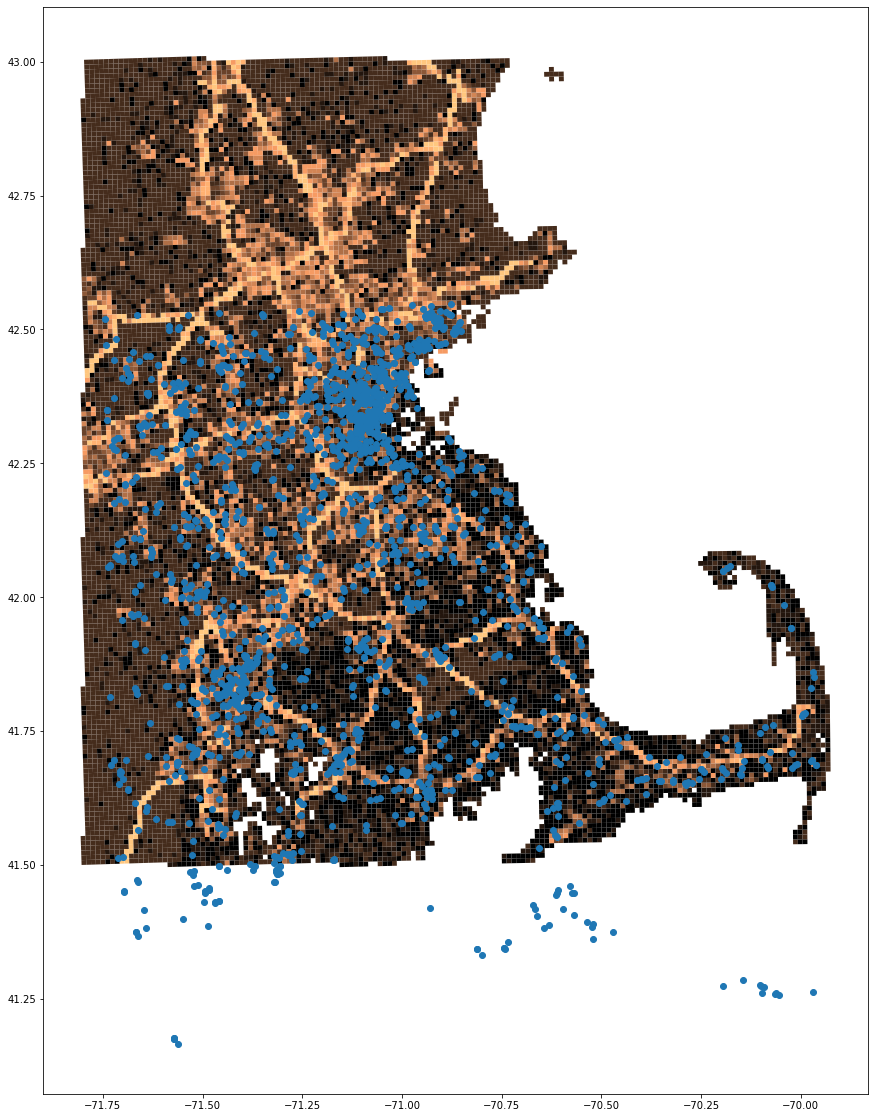

In [60]:
ax=game_grid.plot('Transport',figsize=(20,20),cmap='copper')
locations.plot(figsize=(20,20),ax=ax)
plt.savefig(f'locations_{location_type}.svg', bbox_inches='tight')

In [61]:
# time for every cell is 20 minutes
game_grid['TIME'] = 0
locations_gdf['TIME'] = 0

In [ ]:
for i,x in locations.iterrows():
    mask=x.within(locations_gdf)
    locations_gdf[mask,'TIME']+=20

In [62]:
locations_gdf # print merged GeoDataFrame with cells that contain locations

,kmSQ_ID,GZD,EASTING,NORTHING,MGRS_10km,Shape_Leng,Shape_Le_1,Shape_Area,x_centroid,y_centroid,...,TTL_STAFF,BEDS,HELIPAD,ZIPCODE,CALLSIGN,LOCADD,LOCCITY,LOCSTATE,TOTAL_VEHI,TOTALPERS
MGRS,,,,,,,,,,,,,,,,,,,,,
19TBG8186,BG,19T,281000mE,4686000mN,19TBG88,0.042253,0.042253,0.000109,-71.650728,42.300102,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19TBG7686,BG,19T,276000mE,4686000mN,19TBG78,0.042252,0.042252,0.000109,-71.711321,42.298684,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19TBG7686,BG,19T,276000mE,4686000mN,19TBG78,0.042252,0.042252,0.000109,-71.711321,42.298684,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,59.0
19TCG1585,CG,19T,315000mE,4685000mN,19TCG18,0.042260,0.042260,0.000109,-71.238273,42.299894,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0
19TCG1285,CG,19T,312000mE,4685000mN,19TCG18,0.042259,0.042259,0.000109,-71.274640,42.299178,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19TBG9286,BG,19T,292000mE,4686000mN,19TBG98,0.042257,0.042257,0.000109,-71.517410,42.303108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19TBG9186,BG,19T,291000mE,4686000mN,19TBG98,0.042256,0.042256,0.000109,-71.529531,42.302841,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19TBG9186,BG,19T,291000mE,4686000mN,19TBG98,0.042256,0.042256,0.000109,-71.529531,42.302841,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,40.0


In [584]:
# divide the cells around the first base into 38 different regions based upon angle
# all regions should take the same amount of time
n=100
sorted_locations=locations_gdf.sort_values('THETA')
total=0
region=0
splits=[]
region_splits=np.linspace(0,locations_gdf['TIME'].sum(),n-5)
for i,x in sorted_locations.iterrows():
    if i in locations_gdf.index and not np.isnan(x['TIME']):
        total+=x['TIME']
        if total>=region_splits[region+1]:
            splits.append(i)
            region+=1

In [585]:
# sort game_grid by angle
game_grid = game_grid.sort_values('THETA')

In [586]:
# set region for each sector based upon start and stop cell names
for i,a,b in zip(range(len(splits)),splits,np.roll(splits,1)):
    game_grid.loc[b:a,'REGION']=i

In [587]:
# fix error where first region is set to np.nan
game_grid.loc[game_grid['REGION'].isna(),'REGION'] = 0

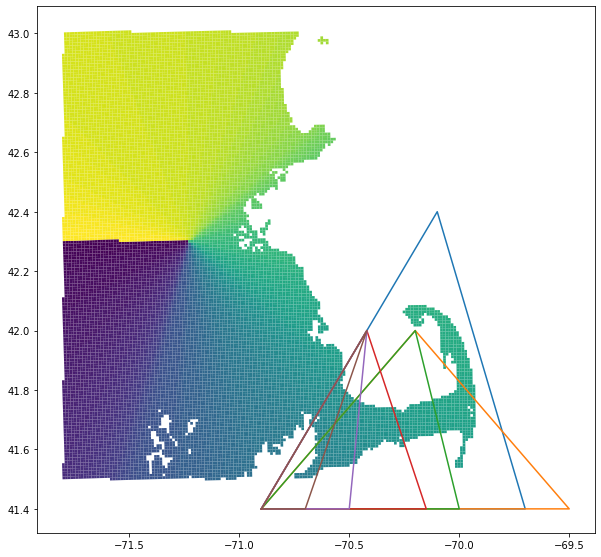

In [588]:
# change region for cape into two seperate regions so trucks don't travel long distances
ax=game_grid.plot('REGION',figsize=(10,10))
cape=Polygon([[-70.9,41.4],[-69.7,41.4],[-70.1,42.4]])
cape_small1=Polygon([[-70.9,41.4],[-69.5,41.4],[-70.2,42.0]])
cape_small2=Polygon([[-70.9,41.4],[-70.0,41.4],[-70.2,42.0]])
cape_small3=Polygon([[-70.9,41.4],[-70.15,41.4],[-70.42,42.0]])
cape_small4=Polygon([[-70.9,41.4],[-70.5,41.4],[-70.42,42.0]])
cape_small5=Polygon([[-70.9,41.4],[-70.7,41.4],[-70.42,42.0]])
ax=plt.plot(*cape.exterior.xy)
ax=plt.plot(*cape_small1.exterior.xy)
ax=plt.plot(*cape_small2.exterior.xy)
ax=plt.plot(*cape_small3.exterior.xy)
ax=plt.plot(*cape_small4.exterior.xy)
ax=plt.plot(*cape_small5.exterior.xy)

In [589]:
# set region for each cape 
game_grid.loc[game_grid.within(cape),'REGION'] = n-1
game_grid.loc[game_grid.within(cape_small1),'REGION'] = n-2
game_grid.loc[game_grid.within(cape_small2),'REGION'] = n-3
game_grid.loc[game_grid.within(cape_small3),'REGION'] = n-4
game_grid.loc[game_grid.within(cape_small4),'REGION'] = n-5
game_grid.loc[game_grid.within(cape_small5),'REGION'] = n-6

In [590]:
# combine grid cells into polygon for each region
region_polygons=gpd.GeoDataFrame(geometry=game_grid.groupby('REGION').apply(lambda x:x.unary_union))

In [591]:
# choose colors for 3-coloring
colors=np.arange(len(region_polygons))%3

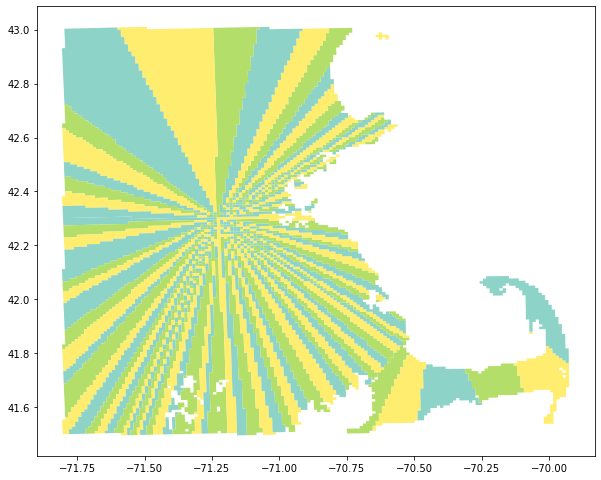

In [592]:
# plot the regions
region_polygons.plot(colors,figsize=(10,10),cmap='Set3')
plt.savefig(f'regions_{location_type}.svg', bbox_inches='tight')

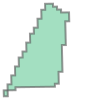

In [593]:
region_polygons.loc[95.0].geometry

In [594]:
# set regions in locations GeoDataFrame to be same as in game_grid
locations_gdf['REGION'] =game_grid['REGION']

In [595]:
locations_gdf.groupby('REGION').count()

,kmSQ_ID,GZD,EASTING,NORTHING,MGRS_10km,Shape_Leng,Shape_Le_1,Shape_Area,x_centroid,y_centroid,...,TTL_STAFF,BEDS,HELIPAD,ZIPCODE,CALLSIGN,LOCADD,LOCCITY,LOCSTATE,TOTAL_VEHI,TOTALPERS
REGION,,,,,,,,,,,,,,,,,,,,,
0.0,17,17,17,17,17,17,17,17,17,17,...,0,0,0,2,0,0,0,0,6,6
1.0,18,18,18,18,18,18,18,18,18,18,...,2,2,2,3,2,2,2,2,4,4
2.0,18,18,18,18,18,18,18,18,18,18,...,1,1,1,2,1,1,1,1,5,5
3.0,17,17,17,17,17,17,17,17,17,17,...,0,0,0,2,2,2,2,2,5,5
4.0,17,17,17,17,17,17,17,17,17,17,...,0,0,0,1,2,2,2,2,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95.0,18,18,18,18,18,18,18,18,18,18,...,2,2,2,3,1,1,1,1,5,5
96.0,21,21,21,21,21,21,21,21,21,21,...,0,0,0,1,2,2,2,2,9,9
97.0,17,17,17,17,17,17,17,17,17,17,...,1,1,1,1,0,0,0,0,7,7


In [596]:
# get node ids for every region
region_ids = locations_gdf.groupby('REGION').apply(lambda x: list(x.index)).to_list()

In [597]:
# add first base to all regions, so it is added in the route
for x in region_ids:
    for base in bases:
        if base not in x:
            x.append(base)

In [598]:
# list of all nodes possible to visit
graph_nodes=list(locations_gdf.index)+list(bases)

In [599]:
# calculate completed subgraph on nodeList
def shortestPathNetwork(nodeList, ogNetwork):
    shortest_path_matrix = np.zeros([len(nodeList),len(nodeList)])
    for idx_i, orig in enumerate(tqdm(nodeList)):
        shortest_paths = nx.single_source_dijkstra_path_length(ogNetwork, orig, weight='weight')
        for idx_j, dest in enumerate(nodeList):
            shortest_path_matrix[idx_i, idx_j] = shortest_paths[dest]
    smallGraph = nx.from_numpy_matrix(shortest_path_matrix, create_using=nx.MultiDiGraph)
    smallGraph = nx.relabel_nodes(smallGraph,{k:v for k, v in zip(smallGraph.nodes, nodeList)})
    return smallGraph

In [600]:
# calculate complete graph for all shelers
#graph=shortestPathNetwork(graph_nodes,G)

In [601]:
graph

In [602]:
# calculate complete graph for every region where all nodes are connected
graphs = [graph.subgraph(x) for x in region_ids]

In [603]:
get_length_of_path = lambda path, temp_graph: np.sum([temp_graph.get_edge_data(i, j, 0)['weight'] for i,j in zip(path,np.roll(path,1)) if i!=j])

In [604]:
# for every graph, calculate the TSP (Travelling Salesman Problem) using greedy and refine with 2-opt
# print the time to travel over every path
import itertools
def calculate_paths(graphs,base):
    paths=[]
    for g in graphs:
        temp_graph=g.copy()
        temp_graph.remove_node(bases[1-bases.index(base)])
        node=base
        path=[]
        while len(temp_graph)>1:
            path.append(node)
            arr={x:temp_graph[node][x][0]['weight'] for x in temp_graph.neighbors(node)}
            temp_graph.remove_node(node)
            node=min(arr,key=arr.get)
        temp_graph=g.copy()
        temp_graph.remove_node(bases[1-bases.index(base)])
        length=get_length_of_path(path,temp_graph)
        best_distance,new_distance=np.inf,0
        while new_distance<best_distance:
            for i, k in itertools.combinations(range(len(path)),r=2):
                new_route = path[:i]+list(reversed(path[i:k+1]))+path[k+1:]
                new_distance = get_length_of_path(new_route,temp_graph)
                if new_distance<best_distance:
                    path,best_distance = new_route, new_distance
        paths.append((path,(get_length_of_path(path,temp_graph)*120/100+len(temp_graph)*20)/60))
    return paths

In [605]:
# calculate minimum paths and lengths
paths, lengths=list(zip(*[x if x[1]<=y[1] else y for x,y in zip(*[calculate_paths(graphs,base) for base in bases])]))

In [606]:
lengths

(7.068412698412699,
 7.778888888888889,
 6.8140873015873025,
 7.370515873015873,
 7.2248809523809525,
 8.362976190476191,
 8.993730158730159,
 8.646031746031747,
 8.461507936507937,
 7.3208730158730155,
 9.829007936507937,
 8.791309523809524,
 9.756309523809525,
 9.939166666666667,
 8.25579365079365,
 6.689285714285715,
 6.757380952380953,
 6.531785714285714,
 7.084960317460316,
 7.36015873015873,
 6.561190476190476,
 6.7763888888888895,
 8.058531746031745,
 8.098968253968254,
 7.976071428571429,
 11.350714285714286,
 8.548809523809522,
 9.616507936507935,
 10.013769841269841,
 10.514603174603174,
 7.465992063492063,
 9.042499999999999,
 8.237460317460318,
 8.587341269841268,
 7.534444444444444,
 9.046269841269842,
 8.334722222222222,
 8.979682539682539,
 10.367738095238094,
 8.833849206349207,
 7.7941666666666665,
 6.437619047619048,
 7.149365079365079,
 7.672023809523809,
 7.616746031746032,
 7.262261904761904,
 6.113888888888888,
 4.456031746031746,
 6.666825396825394,
 8.0490476190

In [609]:
paths[n-6]

['19TCG6407',
 '19TCG6507',
 '19TCG6712',
 '19TCG6717',
 '19TCG6721',
 '19TCG6822',
 '19TCG7131',
 '19TCG7123',
 '19TCG7126',
 '19TCG6925',
 '19TCG6926',
 '19TCG1752',
 '19TCG6623',
 '19TCG6519',
 '19TCG6517',
 '19TCG6616',
 '19TCG6511',
 '19TCG6508',
 '19TCG6306']

In [642]:
new_path=[]
new_path2=[]

In [643]:
for x in paths[n-6]:
    if game_grid.loc[x,'y_centroid']<=41.71592941653868:
        new_path.append(x)
    else:
        new_path2.append(x)

In [644]:
new_paths=[]

In [645]:
for i in range(n):
    if i==n-6:
        new_paths.append([bases[1]]+new_path)
    else:
        new_paths.append(paths[i])
new_paths.append(new_path2)

In [654]:
graphs.append(graphs[n-6].copy())

In [669]:
new_lengths=[]

In [670]:
for i in range(n):
    if i==n-6:
        new_lengths.append((get_length_of_path(new_paths[n-6],graphs[n-6])*120/100+len(new_paths[n-6])*20)/60)
    else:
        new_lengths.append(lengths[i])
new_lengths.append((get_length_of_path(new_paths[n],graphs[n-6])*120/100+len(new_paths[n])*20)/60)

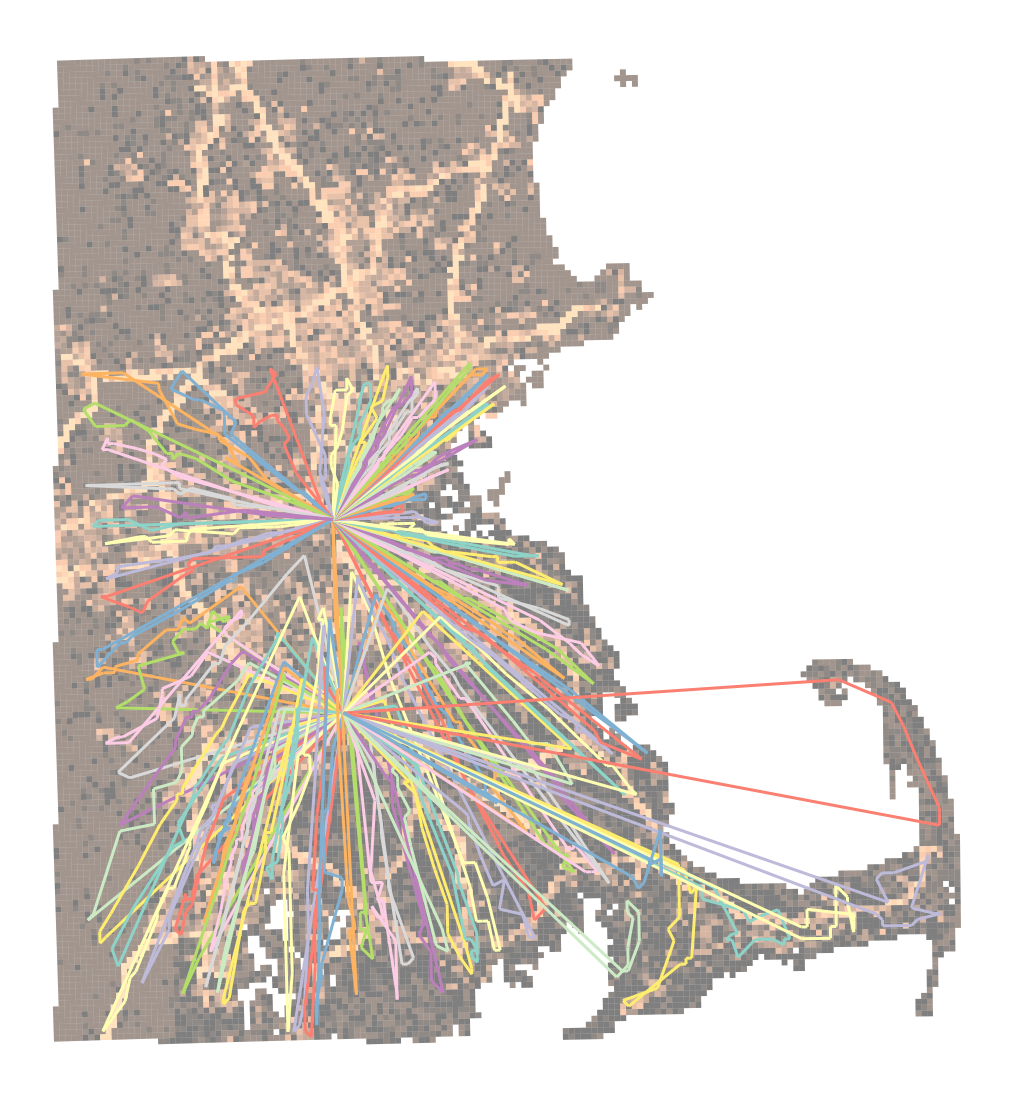

In [656]:
# graph all of the paths
pos=game_grid[['x_centroid','y_centroid']].T.to_dict('list')
edge_data=[]
for i, temp_graph,path in list(zip(range(n+1),graphs,new_paths)):
    weights=nx.get_edge_attributes(temp_graph,'weight')
    edge_data+=[ (x,i%12) for x in zip(path,np.roll(path,1)) if x[0]!=x[1]]
edges,weights=zip(*edge_data)
ax=game_grid.plot('Transport',figsize=(20,20),alpha=0.5,cmap='copper')
nx.draw(G,pos=pos,edgelist=edges,node_size=0,width=3,edge_color=weights,ax=ax,edge_cmap=plt.cm.Set3)
plt.savefig(f'paths_{location_type}.svg', bbox_inches='tight')

In [736]:
new_paths2=[np.roll(np.array(p),-np.where(np.array(p)==bases[0])[0]) for p in new_paths if bases[0] in np.array(p)]
new_paths2+=[np.roll(np.array(p),-np.where(np.array(p)==bases[1])[0]) for p in new_paths if bases[1] in np.array(p)]

In [739]:
import csv
with open('paths_all_locations.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['LENGTH','PATH'])
    writer.writerows(zip(new_lengths,new_paths2))